# Week 4

In [159]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [231]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
import sys
sys.path.append("../")
import edhec_risk_kit as erk

In [233]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

If one could reliably predict future returns, one would not need or seek diversification; one would instead invest in the highest returning asset at each point in time. Crystal balls, however, hardly exist in the real world, and this is the reason why investors should instead hold well-diversified portfolios. 

**Well-diversified portfolios** are scientifically defined as portfolios that deliver the highest reward for a given risk budget. In the absence of parameter uncertainty, and if volatility is used as a risk measure, this leaves us with a simple prescription, namely maximize the Sharpe ratio.

This definition, however, is not fully operational because of the presence of parameter uncertainty. In this context, one can turn to **naive diversification, which focuses on the question of how to construct a well-balanced portfolio (mean goal) as a proxy for constructing a well-diversified portfolio (end goal)**. While naive diversification is often taken to imply an equally-weighted portfolio, the approach can be extended to imply an equal allocation in terms of contributions from underlying factors to the risk of the portfolio. In this module, we explore practical issues in the implementation well-diversified portfolios and we work through the mechanics of various portfolio optimization methodologies and discuss their pros and cons in applications to the construction of improved equity benchmarks.

> The word **risk** derives from the early Italian risicare, which means **to dare**. In this sense, risk is a choice rather than a fate. The actions we dare to take, which depend on how free we are to make choices, are what the story of risk is all about.

_Peter L. Bernstein, Against the Gods: The Remarkable Story of Risk_

## Naive Diversification VS Scientific Diversification

Intuition and portfolio theory suggests that we should hold **well-diversified portfolios**. Like the proverb that we should **not put our eggs in the same basket**.

### Effective number of constituents

The **naive approach diversification** suggests that we should evenly balance dollars across portfolio constituents. There happens to exist **a quantitative measure of how well balanced any portfolio is**. 

This measure is known as the **effective number of constituents (ENC)** and it is defined as follows. 
Suppose we have a set of $N$ assets to choose from, and we have constructed a portfolio in these $N$ assets. Thus we have a set of $N$ weights $\{w_i\}_{i=1,\dots,N}$. We define:
$$
\text{ENC} := \left(\sum_{i=1}^N w_i^2 \right)^{-1}.
$$

**Example 1**: suppose the extreme case in which our weights portfolio result to be $w_1=1$ and $w_i=0$ for all $i=2,\dots,N$. Then:
$$
\text{ENC} := \left(\sum_{i=1}^N w_i^2 \right)^{-1} = 1,
$$
which means that although our portfolio consists, in theory, of $N$ we are effectively investing in (take advantage of) one asset only.

**Example 2**: now, suppose the other extreme case in which we have an equally weigth portfolio, i.e., we have $w_i=1/N$ for all $i=1,\dots,N$. Then:
$$
\text{ENC} := \left(\sum_{i=1}^N w_i^2 \right)^{-1} 
= \left(\sum_{i=1}^N \frac{1}{N^2} \right)^{-1} 
= \left(\frac{1}{N}\right)^{-1} = N,
$$
which means, as expected, that the effective number of constituents of our portfolio is $N$. 

As a further example, we can see what are the effective number of constituents of the Fama-French 
industries cap-weigthed portfolios. Let us consider the case of $49$ industries:

In [5]:
nind = 49
ind_mkt_caps = erk.get_ind_market_caps(nind=nind, weights=True)
#tot_mkt_ind  = erk.get_total_market_index(nind=nind)

In [6]:
# compute the ENC
enc = (ind_mkt_caps**2).sum(axis=1)**(-1)

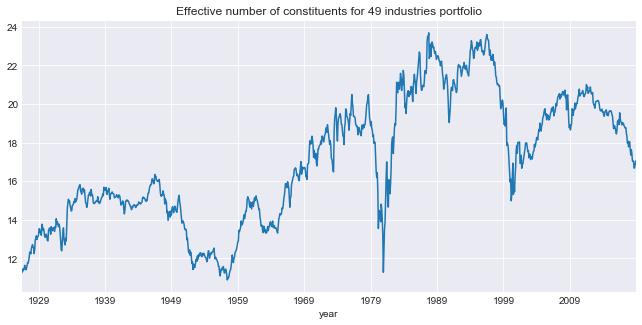

In [7]:
fig, ax = plt.subplots(1,1,figsize=(11,5))
enc.plot(ax=ax, grid=True, title="Effective number of constituents for 49 industries portfolio")
ax.set_xlabel("ENC")
ax.set_xlabel("year")
plt.show()

In [8]:
enc.idxmax(), enc.max(), 

(Period('1987-10', 'M'), 23.681056534437236)

We see that even if we are investing in $49$ industries, the maximum number of **effective constituents** of the portofolio is about $23$ industries in $1987$. This is because, since we are holding a cap-weigthed portfolio, there will be many industries with allocation weights close to zero. 

When we apply this measure to some well-known cap-weighted index market benchmarks such as the **S\&P500 Index**, we come to the conclusion that such indices are not necessarily well-balanced, **they tend to be fairly concentrated** (in about only $100$ stocks).

### Balancing the GMV portfolio

We recall that **the most attractive portfolio is the MSR portfolio**, but unfortunately, it is not always practical due to the presence of large estimation errors in expected return estimate (in such portfolio, we have to miximize the sharpe ratio which include the expected return).

We know that there is a second remarkable portfolio on the efficient frontier, the **GMV portfolio**, 
**the estimation of which does not require any expected return estimates**. 

**The GMV portfolios**, however, **tend to be heavily concentrated in low volatiliy components**. 
In fact, due to the fact that we do not bother about the expected return, we only are concerned, in this case, in minimizing the volatility. Thus, **the minimization process tend to overweight assets with lowest volatility levels**. As a result, the GMV portfolio is a **concentrated portfolio**, i.e., it has a small number of ENCs.

Again, let us construct the GMV portfolio consisting of the $49$ industries (data from $2000$):

In [9]:
# Load returns
ind_rets = erk.get_ind_file(filetype="rets", nind=nind)["2000":] 
ind_rets.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
2000-01,-0.0450,-0.1033,0.1970,-0.0228,-0.0862,-0.1381,0.0391,-0.0062,-0.0651,-0.1138,...,-0.1384,-0.0956,0.0899,-0.1453,-0.0739,-0.0254,-0.0727,0.0140,-0.0681,-0.0036
2000-02,0.0816,-0.0708,-0.0828,-0.1164,-0.0401,0.0042,-0.0195,-0.0061,-0.1157,-0.1278,...,-0.1307,-0.0535,0.0113,-0.0393,-0.1203,-0.1131,-0.1276,0.0309,0.0672,-0.0107
2000-03,0.0426,0.1076,-0.0029,0.0013,0.0511,0.0769,0.1076,0.1312,-0.1426,0.2506,...,0.1265,0.1287,0.0659,0.1436,0.1598,0.1506,0.2287,0.0312,0.1474,-0.0153
2000-04,-0.0761,-0.0408,-0.0080,0.0368,0.0379,0.0027,0.0236,-0.0754,0.0429,0.0430,...,-0.0787,0.0348,-0.0107,-0.0560,0.0382,-0.0285,-0.0040,-0.0725,-0.1256,0.0707
2000-05,-0.0247,0.1806,-0.0724,0.1187,0.1951,0.0115,0.0120,-0.0634,0.0279,-0.0504,...,-0.0212,-0.0363,0.0193,-0.0304,-0.0421,0.0796,0.0731,-0.0341,-0.0694,0.0976


In [10]:
ann_ind_rets = erk.annualize_rets(ind_rets, periods_per_year=12)
cov_mat_rets = erk.sample_cov(ind_rets)
gmv_w = erk.minimize_volatility(ann_ind_rets, cov_mat_rets)
enc = (gmv_w**2).sum()**(-1)
print("ENC: {:.2f}".format(enc))

ENC: 7.69


The portfolio, effectively consists of about only $7$ industries (out of total $49$).

### Improving the GMV portfolio

How can we improve the GMV portfolio so that it is also a fairly **well-diversified portfolio**, in particular, in that sense that it will generate a higher reward per unit of risk (Sharpe ratio) 
compared to a naive portfolio such as the EW portfolio? 

A first method is to the minimize portfolio variance **subject to a minimum number of effective constituents target** $\text{ENC}_0$. 
In this case, we are forcing a minimum degree of naive diversification 
within this scientific diversification process which has been shown to work nicely:
$$
\begin{align}
\text{minimize} \;\;\, &\frac{1}{2}\mathbf{w}^T\Sigma\mathbf{w},    \\
%\mathbf{w}^T\mathbf{1} = 1
\left(\mathbf{w}^T \mathbf{w}\right)^{-1} & = \text{ENC}_0. 
\end{align}
$$
In particular, the GMV portfolio with a minimum number of ENCs tend to be better than the EW 
portfolio in terms of risk-reward trade-off.

A second methodology is imposing that **all portfolio components have the same volatility**, $\sigma_i = \sigma_j = \hat{\sigma}$, for all $i,j$. That is, we can rewrite the minimization as:
$$
\text{minimize} \;\;\, \frac{1}{2}\mathbf{w}^T\Sigma\mathbf{w} =
\frac{1}{2} \sum_{i,j} w_i, w_j \sigma_i, \sigma_i \rho_{ij}
\quad\Longrightarrow\quad 
\text{minimize} \;\;\, \frac{1}{2}\mathbf{w}^T\Sigma\mathbf{w} =
\hat{\sigma} \frac{1}{2} \sum_{i,j} w_i, w_j \rho_{ij}.
$$
In this case we called such portfolio, as the **max decorrelation portfolio**, and here we force the optimizer to make a smart use of the correlation structure as opposed to merely overweighting low volatility components.

## Risk contributions

An important concept when constructing well-balanced portfolios is the **risk contribution** of the components. This is important because even in the case of a well-balanced portfolio in terms of dollar allocation, such as in an equally weighted portfolio, the portfolio can actually hide fairly concentrated **contribution of components to the riskiness of the portfolio**. 

In other words, the portfolio may looks well-balanced in terms of dollar allocation but it is 
not well-balanced in terms of risk allocation.

The risk contribution of an asset to the portfolio is defined as follow. Let us write the volatiltiy of a portfolio as:
$$
\sigma_p^2 = \sum_{i=1}^N w_i^2\sigma_i^2 + \sum_{i\neq j} w_i w_j \sigma_i \sigma_j \rho_{ij}.
$$
Then, the risk contribution of the $i$th asset of the portfolio is given by:
$$
p_i := \frac{ w_i^2\sigma_i^2 + \sum_{i\neq j} w_i w_j \sigma_i \sigma_j \rho_{ij}   }{\sigma_p^2}.
$$


As an example, suppose we have a portfolio of two assets: 
$w_1=0.5$ in a stock with volatility $\sigma_1=0.3$ and $w_2=0.5$ in a bond with volatility $\sigma_2=0.1$. Furthermore, assume that the bond and the stock are uncorrelated, i.e., $\rho_{12}=0=\text{Cov}(r2,r2)$. 
Then, the variance of such portfolio is:
$$
\sigma_p^2 = w_1^2\sigma_1^2 + w_2^2\sigma_2^2 = 
\underbrace{0.5^2\cdot 0.3^2}_{\text{stock contribution}} + \underbrace{0.5^2\cdot 0.1^2}_{\text{bond contribution}} = 0.025,
$$
where notice that there is no the correlation term since the assets are uncorrelated. 
Let us compute the contributions to the volatility of the two assets:
$$
\begin{align}
p_1 &= \frac{w_1^2\sigma_1^2}{\sigma^2_p} = \frac{0.5^2\cdot 0.3^2}{0.025} = 90\%,     \\
p_2 &= \frac{w_2^2\sigma_2^2}{\sigma^2_p} = \frac{0.5^2\cdot 0.1^2}{0.025} = 10\%.
\end{align}
$$
We see that the stock contributes to $90\%$ of the risk of the portfolio while 
the bond only contributes to $10\%$ of the risk of the portfolio. 
In other words, even though the portfolio is really well-balanced, $50\%-50\%$, because of those differences in intrinsic risk levels between the portfolio components, the portfolio happens to be extremely concentrated when it comes to risk contributions.

We can also consider the case of correlated assets. Suppose that the stock and the bond are correlated and they have $\rho_{12}=0.25$. 
The variance now would be:
$$
\sigma_p^2 = w_1^2\sigma_1^2 + w_2^2\sigma_2^2 + 2 w_1 w_2 \sigma_1 \sigma_2 \rho_{12} 
= \underbrace{w_1^2\sigma_1^2 + w_1 w_2 \sigma_1 \sigma_2 \rho_{12}}_{\text{stock contribution}} 
+ \underbrace{w_2^2\sigma_2^2 + w_1 w_2 \sigma_1 \sigma_2 \rho_{12}}_{\text{bond contribution}} 
= 0.0288,
$$
and now we have:
$$
\begin{align}
p_1 &= \frac{ w_1^2\sigma_1^2 + w_1 w_2 \sigma_1\sigma_2 \rho_{12} }{\sigma^2_p} 
= \frac{0.5^2\cdot 0.3^2 + 0.5\cdot 0.5\cdot 0.3\cdot 0.1 \cdot 0.25}{0.0288} \simeq 85\%, \\
p_2 &= \frac{ w_2^2\sigma_2^2 + w_1 w_2 \sigma_1 \sigma_2 \rho_{12}     }{\sigma^2_p} 
= \frac{0.5^2\cdot 0.1^2 + 0.5\cdot 0.5\cdot 0.3\cdot 0.1 \cdot 0.25}{0.0288} \simeq 15\%.  
\end{align}
$$
It is therefore extremely useful to know for each component of your portfolio what is the contribution of that component to the total risk of the portfolio.

## Risk Parity Portfolio

We will refer to as a **risk parity portfolio** (or the **Equal Risk Contribution (ERC)** portfolio) 
to denote the portfolio with **equal risk contribution** from both assets (or more than one). 

### Effective Number of Correlated Bets (ENCB)

Such portfolio con be obtained by **maximizing the effective number of components ENCs applied to the risk contributions, as opposed to the number of contributions**. This quantity will be called the **Effective Number of Correlated Bets (ENCB)** and is then defined as:
$$
\text{ENCB} := \left(\sum_{i=1}^N p_i^2\right)^{-1}. 
$$
As for the ENCs, notice that the ENCB is minimum when there is only one asset component with the maximum risk contribution of $100\%$, i.e., 
we have $p_1=1$ and $p_i=0$ for all $i=2,\dots,N$:
$$
\text{ENCB} := \left(\sum_{i=1}^N p_i^2\right)^{-1} = \frac{1}{p_1^2} = 1,
$$
whereas the ENCB is maximum when all asset components equally contribute to the risk, i.e., $p_i=1/N$ for all $i=1,\dots,N$:
$$
\text{ENCB} := \left(\sum_{i=1}^N p_i^2\right)^{-1} = \left(\frac{1}{N}\right)^{-1} = N.
$$

**Example**: assume an annualized volatility of $15.1\%$ on a broad equity index and annualized volatility of $4.6\%$ on a broad bond index, with a $0.2$ correlation. What is the **ENCB** for the 60/40 portfolio? 

We have $\sigma_1=0.151$, $\sigma_2 = 0.046$, and $\rho_{12} = 0.2$. Then, the volatiltiy of the $60/40$ portfolio is:
$$
\sigma_p^2 = w_1^2\sigma_1^2 + w_2^2\sigma_2^2 + 2 w_1 w_2 \sigma_1 \sigma_2 \rho_{12} 
= 0.6^2 \cdot 0.151^2  + 0.4^2 \cdot 0.046^2  + 2\cdot 0.6\cdot 0.4 \cdot0.151 \cdot 0.046 \cdot 0.2
= 0.009213736,
$$
The corresponding risk contributions are:
$$
\begin{align}
p_1 &= \frac{ w_1^2\sigma_1^2 + w_1 w_2 \sigma_1\sigma_2 \rho_{12} }{\sigma^2_p} 
= \frac{0.6^2\cdot 0.151^2 + 0.6\cdot 0.4\cdot 0.151\cdot 0.046 \cdot 0.2}{ 0.009213736 } \simeq 93\%, \\
p_2 &= \frac{ w_2^2\sigma_2^2 + w_1 w_2 \sigma_1 \sigma_2 \rho_{12}     }{\sigma^2_p} 
= \frac{0.4^2\cdot 0.046^2 + 0.6\cdot 0.4\cdot 0.151\cdot 0.046 \cdot 0.2}{ 0.009213736  } \simeq 7\%.  
\end{align}
$$
Therefore, we have:
$$
\text{ENCB} = \left(\sum_{i=1}^2 p_i^2\right)^{-1} = \frac{1}{p_1^2 + p_2^2} \simeq 1.15.
$$
We can see that the ENCB is much closer to $1$ than to $2$ (the total number of asset components), which suggest a not balanced portfolio in term of risk.

### Two assets case

In the two asset case, the **risk-parity weights** are proportional to the the inverse of volatility weigths. If we write the risk contributions as follows:
$$
\begin{align}
p_1 &= \frac{ w_1^2\sigma_1^2 + w_1 w_2 \sigma_1\sigma_2 \rho_{12} }{\sigma^2_p} 
= \frac{ w_1^2\sigma_1^2 }{\sigma^2_p} + \frac{w_1 w_2 \sigma_1\sigma_2 \rho_{12}}{\sigma^2_p},   \\
p_2 &= \frac{ w_2^2\sigma_2^2 + w_1 w_2 \sigma_1\sigma_2 \rho_{12} }{\sigma^2_p} 
= \frac{ w_2^2\sigma_2^2 }{\sigma^2_p} + \frac{w_1 w_2 \sigma_1\sigma_2 \rho_{12}}{\sigma^2_p},
\end{align}
$$
and we impose the risk parity $p1=p2$, this leads us to:
$$
p_1 = p_2 
\quad\Longrightarrow\quad
\frac{ w_1^2\sigma_1^2 }{\sigma^2_p} + \frac{w_1 w_2 \sigma_1\sigma_2 \rho_{12}}{\sigma^2_p}
=
\frac{ w_2^2\sigma_2^2 }{\sigma^2_p} + \frac{w_1 w_2 \sigma_1\sigma_2 \rho_{12}}{\sigma^2_p} 
\quad\Longrightarrow\quad
\frac{w_1}{w_2} = \frac{\sigma_2}{\sigma_1}.
$$
If we want the weights to sum up to $1$, we have to solve the following system:
\begin{cases}
w_1 / w_2 &= \sigma_2 / \sigma_1 \\
w_1 + w_2 &= 1,
\end{cases}
whose solution is:
$$
w_1 = \frac{\sigma_2}{\sigma_1 + \sigma_2}   
\quad\text{and}\quad
w_2 = \frac{\sigma_1}{\sigma_1 + \sigma_2}.
$$

If we take the previous example:
$$
w_1 = \frac{\sigma_2}{\sigma_1 + \sigma_2} = \frac{0.046}{0.046 +  0.151} \simeq 23.4\% 
\quad\text{and}\quad
w_2 = \frac{\sigma_1}{\sigma_1 + \sigma_2} = \frac{0.151}{0.046 +  0.151} \simeq 77\%. 
$$

As expected, **risk parity portfolios tend to overweight the least volatile asset components or the least risky components**, 
and they have become extremely popular in practice as a way to build well-balanced portfolio with a focus on risk analysis at the overall portfolio level.

Furthermore, **risk parity portfolios tend to be better diversified compared to CW portfolios, so ENCs is generally higher**.

In [186]:
nind = 49
inds = ['Beer','Hlth','Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_file(filetype="rets", nind=nind)["1974":]
ind_mcap = erk.get_ind_market_caps(nind=nind, weights=True)["1974":]
mat_cov  = ind_rets.cov()

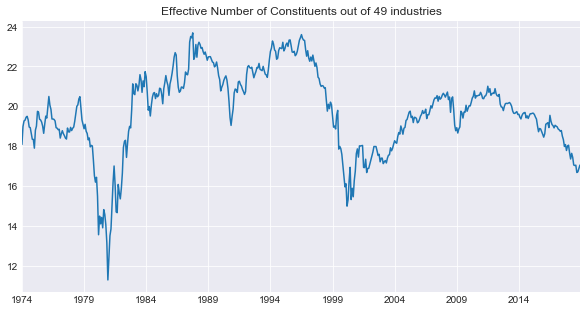

In [187]:
ENC = ind_mcap.T.aggregate( erk.enc )
ENC.plot(grid=True, figsize=(10,5), title="Effective Number of Constituents out of 49 industries")
plt.show()

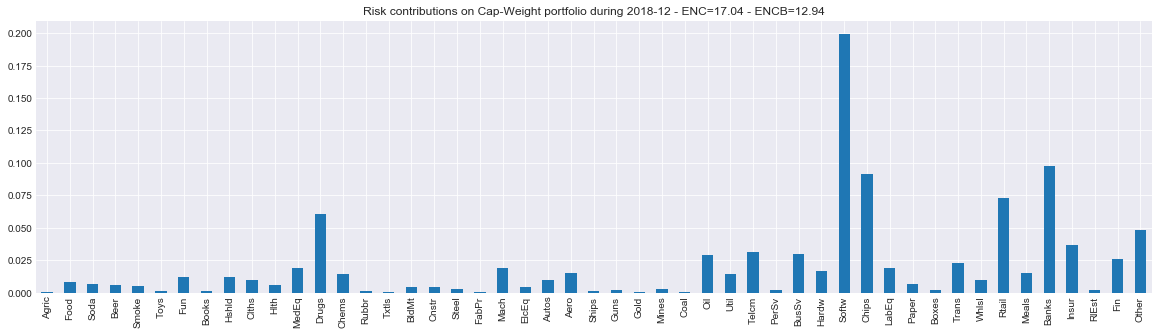

In [188]:
last_weigths = ind_mcap.loc["2018-12"]

# risk contributions on 2018-12
p = erk.portfolio_risk_contributions( last_weigths, mat_cov )

# compute the ENC
ENC = erk.enc(last_weigths)

# compute the ENCB
ENCB = erk.encb(p)

p.plot.bar(grid=True, figsize=(20,5), 
           title="Risk contributions on Cap-Weight portfolio during 2018-12 - ENC={:.2f} - ENCB={:.2f}".format(ENC,ENCB))
plt.show()

Let us see what are the risk contributions if we construct an equally weigthed portfolio, i.e., we assign $w_i=1/49$ for all $i$:

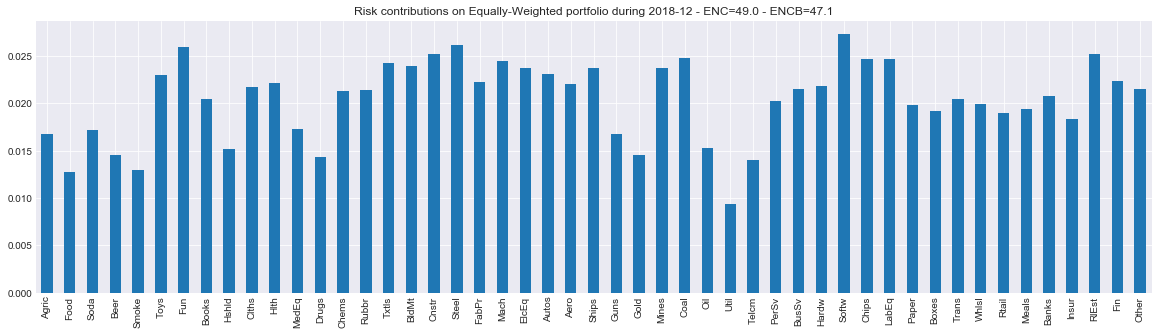

In [189]:
# equally weigths 
ew_weigths = erk.weight_ew(ind_rets) # 1/49

# risk contributions on 2018-12
p = erk.portfolio_risk_contributions( ew_weigths, mat_cov )

# compute the ENC
ENC = erk.enc(ew_weigths)

# compute the ENCB
ENCB = erk.encb(p)

p.plot.bar(grid=True, figsize=(20,5), 
           title="Risk contributions on Equally-Weighted portfolio during 2018-12 - ENC={:.1f} - ENCB={:.1f}".format(ENC,ENCB))
plt.show()

We can see that that avery asset component contributes to the risk much more than in the cap-weight case. 
Also, notice that now $\text{ENC}=49$ while the ENCB is also close to $N=49$.

Let us focus on just 5 industries from 2013 for a moment:

In [190]:
ind  = erk.get_ind_file(filetype="rets", nind=nind)["2013":][inds]
mcap = erk.get_ind_market_caps(nind=nind, weights=True)["2013":][inds]
mat_cov = ind.cov()

We can compute the **risk parity portfolio weights** using the following method:

In [191]:
# weigths of a risk parity portfolio
rp_weigths = erk.risk_parity_weigths(mat_cov)
rp_weigths

array([0.28500558, 0.17604638, 0.16955441, 0.18604053, 0.1833531 ])

that is, these are the weights for which the risk contributions of the 5 assets would be the same, in particular, equal to $1/5=0.2$. 
To verify this, we use our method:

In [192]:
risk_contribs = erk.portfolio_risk_contributions( rp_weigths , mat_cov )
risk_contribs

Beer     0.200025
Hlth     0.199898
Fin      0.200027
Rtail    0.199985
Whlsl    0.200064
dtype: float64

Let us see what are the ENCs and the ENCBs for this portfolio. By construction, we expect $\text{ENBC}=5$:

In [199]:
ENC  = erk.enc(rp_weigths)
ENCB = erk.encb(risk_contribs)
ENC, ENCB 

(4.780145704405837, 4.999999598577305)

In principle, we can use a quadratic optimizer that returns **the weights of a portfolio whose risk contributions 
are as close as possible to a given input target risk contribution vector**. For example suppose that:

In [200]:
target_risk = pd.Series([0.2, 0.3, 0.3, 0.1, 0.1], index=inds)
target_risk

Beer     0.2
Hlth     0.3
Fin      0.3
Rtail    0.1
Whlsl    0.1
dtype: float64

that is, we would like Beer to contribute for the $20\%$, Health for the $30\%$, and so on. Then we can call the following method:

In [201]:
weights = portfolio_risk_contrib_optimizer(target_risk, mat_cov)
weights

array([0.29924547, 0.25502729, 0.25024568, 0.10076747, 0.09471409])

Right. To verify if the risk contributions of the portfolio constructed with the weigths above are close to the given target risk vector we 
call the portfolio_risk_contributions method:

In [202]:
p_risk_contribs = erk.portfolio_risk_contributions(weights, mat_cov)
p_risk_contribs

Beer     0.200146
Hlth     0.300210
Fin      0.300638
Rtail    0.099964
Whlsl    0.099042
dtype: float64

In [203]:
ENC  = erk.enc(weights)
ENCB = erk.encb(p_risk_contribs)
ENC, ENCB 

(4.231290604786237, 4.1602549629221475)

Let us run the usual backtest for the weigthing scheme, where we compare the EW, the CW and the risp parity portfolio:

In [234]:
nind = 49
inds = ['Beer','Hlth','Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_file(filetype="rets", nind=nind)["1974":]
ind_mcap = erk.get_ind_market_caps(nind=nind, weights=True)["1974":]
mat_cov  = ind_rets.cov()

In [235]:
ew_rets = erk.backtest_weight_scheme(ind_rets, window=36, weight_scheme=erk.weight_ew)
cw_rets = erk.backtest_weight_scheme(ind_rets, window=36, weight_scheme=erk.weight_cw, cap_ws=ind_mcap)

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
EW,0.121052,0.161000,0.550248,-0.769256,6.572680,0.103950,0.071993,-0.528292
CW,0.117007,0.149311,0.566996,-0.702445,5.458192,0.096232,0.066685,-0.518076


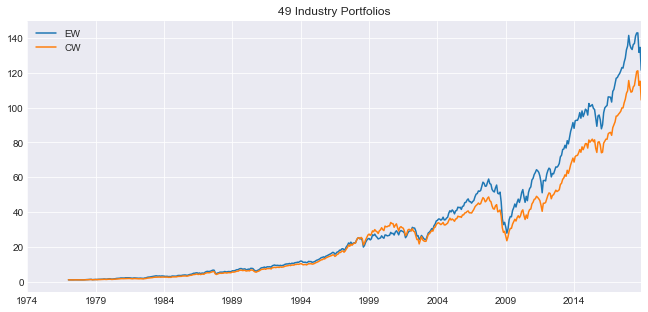

In [237]:
btr = pd.DataFrame({
    "EW": ew_rets, 
    "CW": cw_rets}
)
wealth = (1 + btr).cumprod()
wealth.plot(grid=True, figsize=(11,5), title="49 Industry Portfolios")
erk.summary_stats( btr.dropna() )

Now, let us run a backtest of this risk parity weigthing scheme: 

In [238]:
#### IT TAKES A WHILE
rp_rets = erk.backtest_weight_scheme(ind_rets, window=36, weight_scheme=erk.weight_rp, cov_estimator=erk.sample_cov)

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
EW,0.121052,0.161000,0.550248,-0.769256,6.572680,0.103950,0.071993,-0.528292
CW,0.117007,0.149311,0.566996,-0.702445,5.458192,0.096232,0.066685,-0.518076
RP,0.120185,0.149185,0.588203,-0.872577,7.019237,0.096357,0.066886,-0.502950


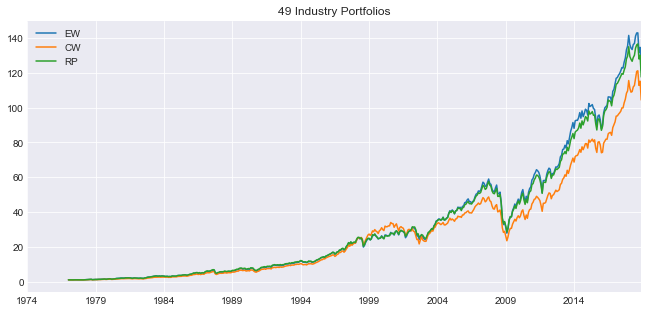

In [239]:
btr["RP"] = rp_rets
wealth = (1 + btr).cumprod()
wealth.plot(grid=True, figsize=(11,5), title="49 Industry Portfolios")
erk.summary_stats( btr.dropna() )